In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    overload dataset
    """

    def __init__ (self, images, labels):
        self.images = images
        self.labels = labels
        self.images = self.images.float()
        self.labels = self.labels.long()

    def __len__ (self): 
        return(len(self.images))

    def __getitem__ (self, idx):
        return self.images[idx], self.labels[idx]
    
    def shuffle(self):
        idx = torch.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]
    
    def train_val_test_split(self, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15):
        # split the data
        self.shuffle()
        train_data = self[:int(train_percentage*self.__len__())]
        val_data = self[int(train_percentage*self.__len__()):int((train_percentage+val_percentage)*self.__len__())]
        test_data = self[int((train_percentage+val_percentage)*self.__len__()):]
        return Dataset(train_data[0], train_data[1]), Dataset(val_data[0], val_data[1]), Dataset(test_data[0], test_data[1])

In [3]:
# load the data
data = torch.load('data/leukemia/leukemia_dataset.pt')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class LeukemiaClassifier(nn.Module):
    def __init__(self):
        super(LeukemiaClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # RGB images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 28 * 28  # Adjusted for 224x224 input size
        self.fc = nn.Linear(fc_input_size, 4) # Adjusted for 4 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        return x

In [21]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create a progress bar for the training loop
    epoch_bar = tqdm(range(epochs), desc='Epochs')
    
    for epoch in epoch_bar:
        # Set the model to training mode
        model.train()

        epoch_losses = []
        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            epoch_losses.append(loss.item())

        # compute the mean of the losses 
        epoch_losses_th = torch.tensor(epoch_losses)
        epoch_mean_losses = torch.mean(epoch_losses_th)
        train_losses.append(epoch_mean_losses)
        
        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))
        
        # update the progress bar
        epoch_bar.set_postfix({'Training Loss': train_losses[-1], 'Validation Loss': val_losses[-1]})
        
    return train_losses, val_losses

In [7]:
#  set the seed before the split
torch.manual_seed(42)
data_train, data_val, data_test = data.train_val_test_split()

# Create the DataLoaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=data_test.__len__(), shuffle=False)


In [22]:
# Example instantiation and training
# model = BrainClassifier()
model = LeukemiaClassifier()
tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=150, lr=0.00001)

tend = time.time()
print("Time elapsed: ", tend-tstart)

Epochs: 100%|██████| 150/150 [02:49<00:00,  1.13s/it, Training Loss=tensor(0.0003), Validation Loss=0.554]

Time elapsed:  169.18532347679138


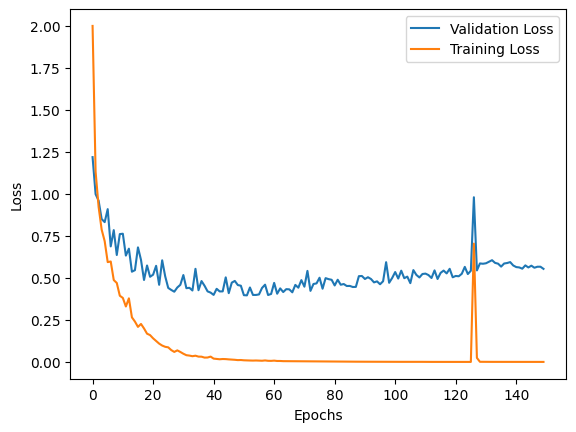

In [25]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Save the model weights
torch.save(model.state_dict(), 'Leukemia_weights.pth')

In [11]:
x, y = next(iter(test_loader))
model.eval()
y_pred = model(x.to(device)).argmax(1)
# y --> label vere
# y_pred --> label modello

In [12]:
# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.8977505112474438


In [14]:
model2 = LeukemiaClassifier()
model2 = model2.to(device)
model2.eval()

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model2(img.float().to(device))
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.3047034764826176
